In [74]:
import numpy as np

import matplotlib.pyplot as plt

from numba import njit, vectorize, float32

from monk import nb

from typing import Callable, Optional

import hoomd
import hoomd.forward_flux.forward_flux as ffs
import gsd.hoomd

from monk import prep
from monk import pair
import ex_render
import pandas as pd

from monk import nb

import pathlib

In [75]:
import importlib
importlib.reload(ffs);

In [55]:
data_dir = pathlib.Path("/home/ian/Documents/Data/monk/states")
data = {}
for file in data_dir.glob("*.gsd"):
    name = file.name
    temp = float(name.split("temp-")[-1].split("_seed")[0])
    if temp >= .65 or temp < 0.5:
        continue

    sub_data = {}
    sub_data["traj"] = file
    sub_data["soft"] = file.parents[0].glob(f"temp-{temp}*.parquet").__next__()
    data[temp] = sub_data

In [84]:
file = "traj.gsd"
soft = "soft.parquet"

In [79]:
pd.read_parquet(soft)

,frames,ids,labels,Xs,softness
1,0,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00011528...",3.033514
3,0,3,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.6650275e...",1.821085
4,0,4,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.669761
5,0,5,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.298171
6,0,6,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00016265...",1.087742
...,...,...,...,...,...
51705,100,505,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.880046e-...",-0.239539
51707,100,507,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.473729
51708,100,508,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.4613153e...",0.989343
51710,100,510,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.138169


In [80]:
from hoomd.custom import Action
import freud
import time

class TrackParticle(Action):

    def __init__(self, pid):
        self._pid = pid
        self.data = []

    def act(self, timestep):
        # if isinstance(self._simulation.device, hoomd.device.CPU):
        with self._state.cpu_local_snapshot as data:
            idx = data.particles.rtag[self._pid]
            self.data.append(np.array(data.particles.position[idx], copy=True))

@njit
def _diff_with_rtag(ref_pos, pos, rtags):
    out = np.zeros_like(pos)
    n = len(rtags)
    for tag_idx in range(n):
        idx = rtags[tag_idx]
        out[idx] = pos[idx] - ref_pos[tag_idx]
    return out

class ZeroDrift(Action):

    def __init__(self, reference_positions, box):
        self._ref_pos = reference_positions
        self._box = freud.box.Box.from_box(box)

    @classmethod
    def from_state(cls, state: hoomd.State):
        return cls(state.get_snapshot().particles.position, state.box)

    def act(self, timestep):
        with self._state.cpu_local_snapshot as data:
            pos = data.particles.position._coerce_to_ndarray()
            rtags = data.particles.rtag._coerce_to_ndarray()
            diff = self._box.wrap(_diff_with_rtag(self._ref_pos, pos, rtags))
            dx = np.mean(diff, axis=0)
            data.particles.position = self._box.wrap(data.particles.position - dx)


In [81]:
import contextlib

In [98]:
def get_basins(snap, ids, seed, temp, steps=10_000, skip=10) -> np.ndarray:

    output = []

    print("temp:", temp)

    cpu = hoomd.device.CPU()
    sim = ffs.ForwardFluxSimulation(cpu, ids[0], seed=seed)
    sim.create_state_from_snapshot(snap)
    integrator = hoomd.md.Integrator(dt=0.0025)
    tree = hoomd.md.nlist.Tree(0.3)
    lj = pair.KA_LJ(tree)

    lang = hoomd.md.methods.Langevin(hoomd.filter.All(), temp)
    integrator.forces = [lj]
    integrator.methods = [lang]
    sim.operations.integrator = integrator

    # set zero drift
    pos = sim.state.get_snapshot().particles.position
    box = sim.state.box
    trigger = hoomd.trigger.Periodic(1)
    remove_drift = hoomd.update.CustomUpdater(trigger, ZeroDrift(pos, box))
    sim.operations.updaters.clear()
    sim.operations.updaters.append(remove_drift)

    basin_output = []

    for id in ids:
        print("    id:", id)
        sim.pid = int(id)
        basin_op = sim.sample_basin(steps, skip)
        basin_output.append(basin_op)
        sim.reset_state()

    return basin_output

In [130]:
def run_ff_job(snap, ids, seed, temp) -> np.ndarray:

    output = []

    print("temp:", temp)

    cpu = hoomd.device.CPU()
    sim = ffs.ForwardFluxSimulation(cpu, ids[0], seed=seed)
    sim.create_state_from_snapshot(snap)
    integrator = hoomd.md.Integrator(dt=0.0025)
    tree = hoomd.md.nlist.Tree(0.3)
    lj = pair.KA_LJ(tree)

    lang = hoomd.md.methods.Langevin(hoomd.filter.All(), temp)
    integrator.forces = [lj]
    integrator.methods = [lang]
    sim.operations.integrator = integrator

    # set zero drift
    pos = sim.state.get_snapshot().particles.position
    box = sim.state.box
    trigger = hoomd.trigger.Periodic(1)
    remove_drift = hoomd.update.CustomUpdater(trigger, ZeroDrift(pos, box))
    sim.operations.updaters.clear()
    sim.operations.updaters.append(remove_drift)

    for id in ids:
        print("    id:", id)
        sim.pid = int(id)
        basin_op = sim.sample_basin(10_000, 1)
        barrier = np.quantile(basin_op, .995)
        print("    barrier:", barrier)
        sim.basin_barrier = barrier
        sim.reset_state()
        # with contextlib.redirect_stdout(None):
        rate, _, _ = sim.run_ff(1_000, collect=10, trials=10, barrier_step=0.01, flex_step=0.001, floor=1e-10, op_thresh=0.4, thresh=0.0)
        output.append(np.log(rate))
        sim.reset_state()
    return np.array(output)

In [115]:
frame = 100
snap = gsd.hoomd.open(file)[frame]
t = snap.log["NVT/kT"][0]
print(t)
df = pd.read_parquet(soft)
ids = np.unique(df["ids"])[:10]
basin_dist = get_basins(snap, ids, 1234, t, steps=10_000, skip=1)

0.4
temp: 0.4
    id: 1
    id: 3
    id: 4
    id: 5
    id: 6
    id: 7
    id: 8
    id: 9
    id: 10
    id: 11


Text(0.5, 0, '$\\Delta x$')

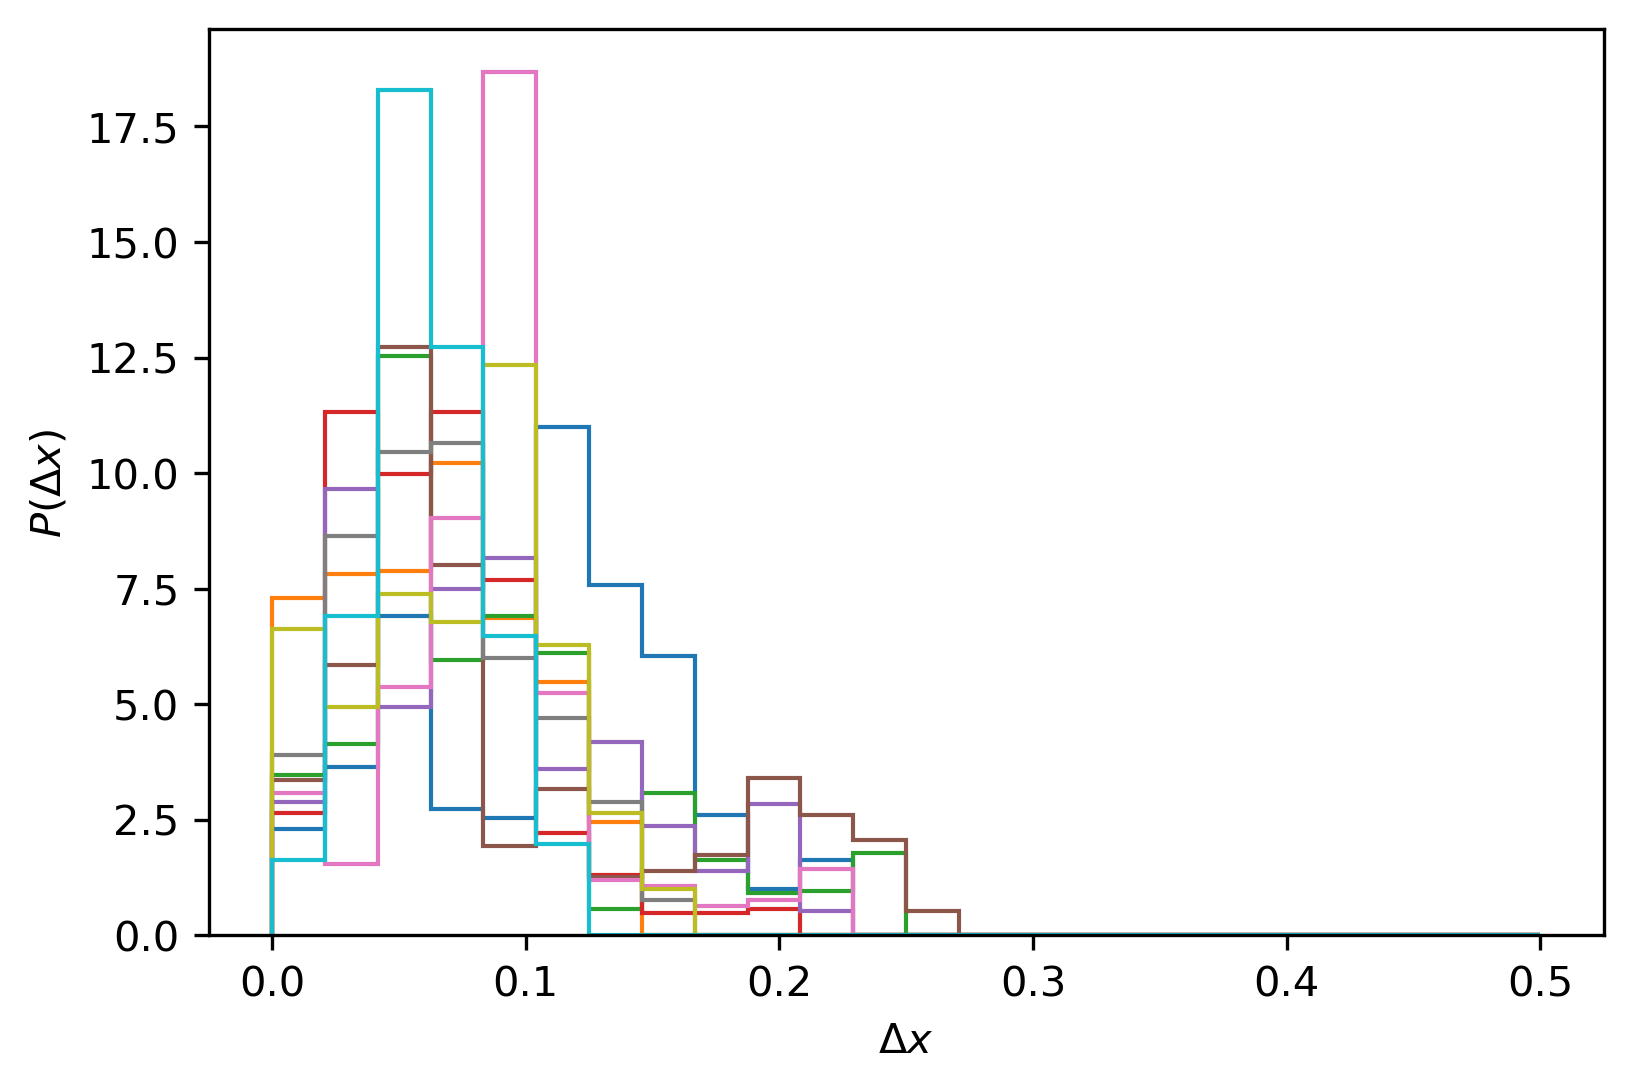

In [118]:
plt.figure(dpi=150)
for dist in basin_dist:
    plt.hist(dist[:1000], bins=np.linspace(0.0, 0.5, 25), histtype="step", density=True)

plt.ylabel(r"$P(\Delta x)$")
plt.xlabel(r"$\Delta x$")

Text(0.5, 0, '$\\Delta x$')

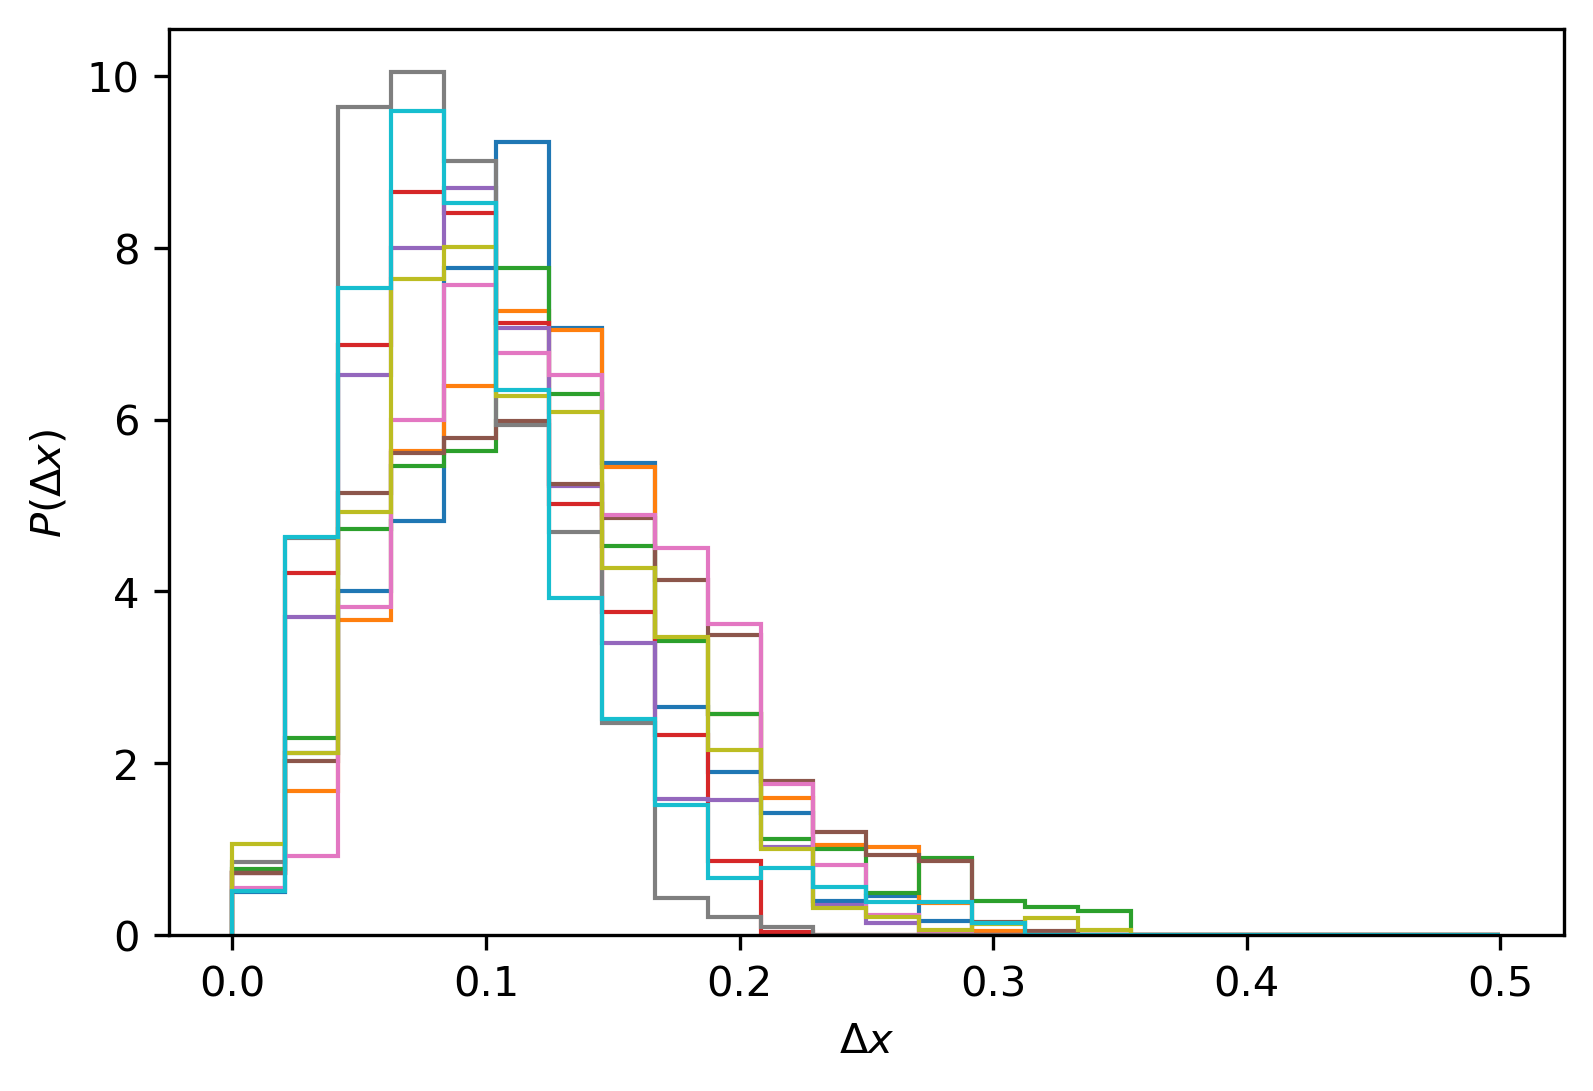

In [117]:
plt.figure(dpi=150)
for dist in basin_dist:
    plt.hist(dist, bins=np.linspace(0.0, 0.5, 25), histtype="step", density=True)

plt.ylabel(r"$P(\Delta x)$")
plt.xlabel(r"$\Delta x$")

In [133]:
frame = 95
snap = gsd.hoomd.open(file)[frame]
t = snap.log["NVT/kT"][0]
print(t)
df = pd.read_parquet(soft)
ids = np.unique(df["ids"])[:25]
dF = run_ff_job(snap, ids, 1234, t)
frame_soft = df[df.frames == frame].softness.values[:25]

0.45000000000000007
temp: 0.45000000000000007
    id: 1
    barrier: 0.25567360127794153
A barrier crossings: 10
state: 0
barrier: 0 0.26567360127794154 (0.0)
final rate: 0.0
state: 1
barrier: 0 0.26567360127794154 (0.0)
final rate: 0.0
state: 2
barrier: 0 0.26567360127794154 (1.0)
barrier: 1 0.27567360127794155 (1.0)
barrier: 2 0.28567360127794156 (1.0)
barrier: 3 0.29567360127794157 (0.9)
barrier: 4 0.3056736012779416 (0.6666666666666666)
barrier: 5 0.3156736012779416 (0.3333333333333333)
barrier: 6 0.32234026794460824 (1.0)
barrier: 7 0.33234026794460825 (0.8)
barrier: 8 0.34234026794460826 (0.375)
barrier: 9 0.34984026794460826 (0.1111111111111111)
barrier: 10 0.3515069346112749 (0.0)
final rate: 0.0
state: 3
barrier: 0 0.26567360127794154 (1.0)
barrier: 1 0.27567360127794155 (1.0)
barrier: 2 0.28567360127794156 (1.0)
barrier: 3 0.29567360127794157 (0.8)
barrier: 4 0.3056736012779416 (1.0)
barrier: 5 0.3156736012779416 (0.875)
barrier: 6 0.3256736012779416 (0.8571428571428571)
barr

/tmp/ipykernel_15528/410863669.py:37: RuntimeWarning: divide by zero encountered in log
  output.append(np.log(rate))


    barrier: 0.2552695543979014
A barrier crossings: 10
state: 0
barrier: 0 0.2652695543979014 (1.0)
barrier: 1 0.2752695543979014 (0.6)
barrier: 2 0.2852695543979014 (0.3333333333333333)
barrier: 3 0.29193622106456807 (0.7)
barrier: 4 0.3012695543979014 (0.14285714285714285)
barrier: 5 0.303936221064568 (0.5)
barrier: 6 0.3066028877312347 (0.0)
final rate: 0.0
state: 1
barrier: 0 0.2652695543979014 (1.0)
barrier: 1 0.2752695543979014 (1.0)
barrier: 2 0.2852695543979014 (1.0)
barrier: 3 0.2952695543979014 (1.0)
barrier: 4 0.30526955439790143 (0.9)
barrier: 5 0.31526955439790144 (0.6666666666666666)
barrier: 6 0.32526955439790145 (0.16666666666666666)
barrier: 7 0.3286028877312348 (1.0)
barrier: 8 0.33526955439790146 (0.8)
barrier: 9 0.34526955439790147 (0.25)
barrier: 10 0.3502695543979015 (0.3)
barrier: 11 0.3532695543979015 (0.4444444444444444)
barrier: 12 0.3559362210645681 (0.0)
final rate: 0.0
state: 2
barrier: 0 0.2652695543979014 (1.0)
barrier: 1 0.2752695543979014 (1.0)
barrier

Text(0, 0.5, '$e^{-\\Delta F}$')

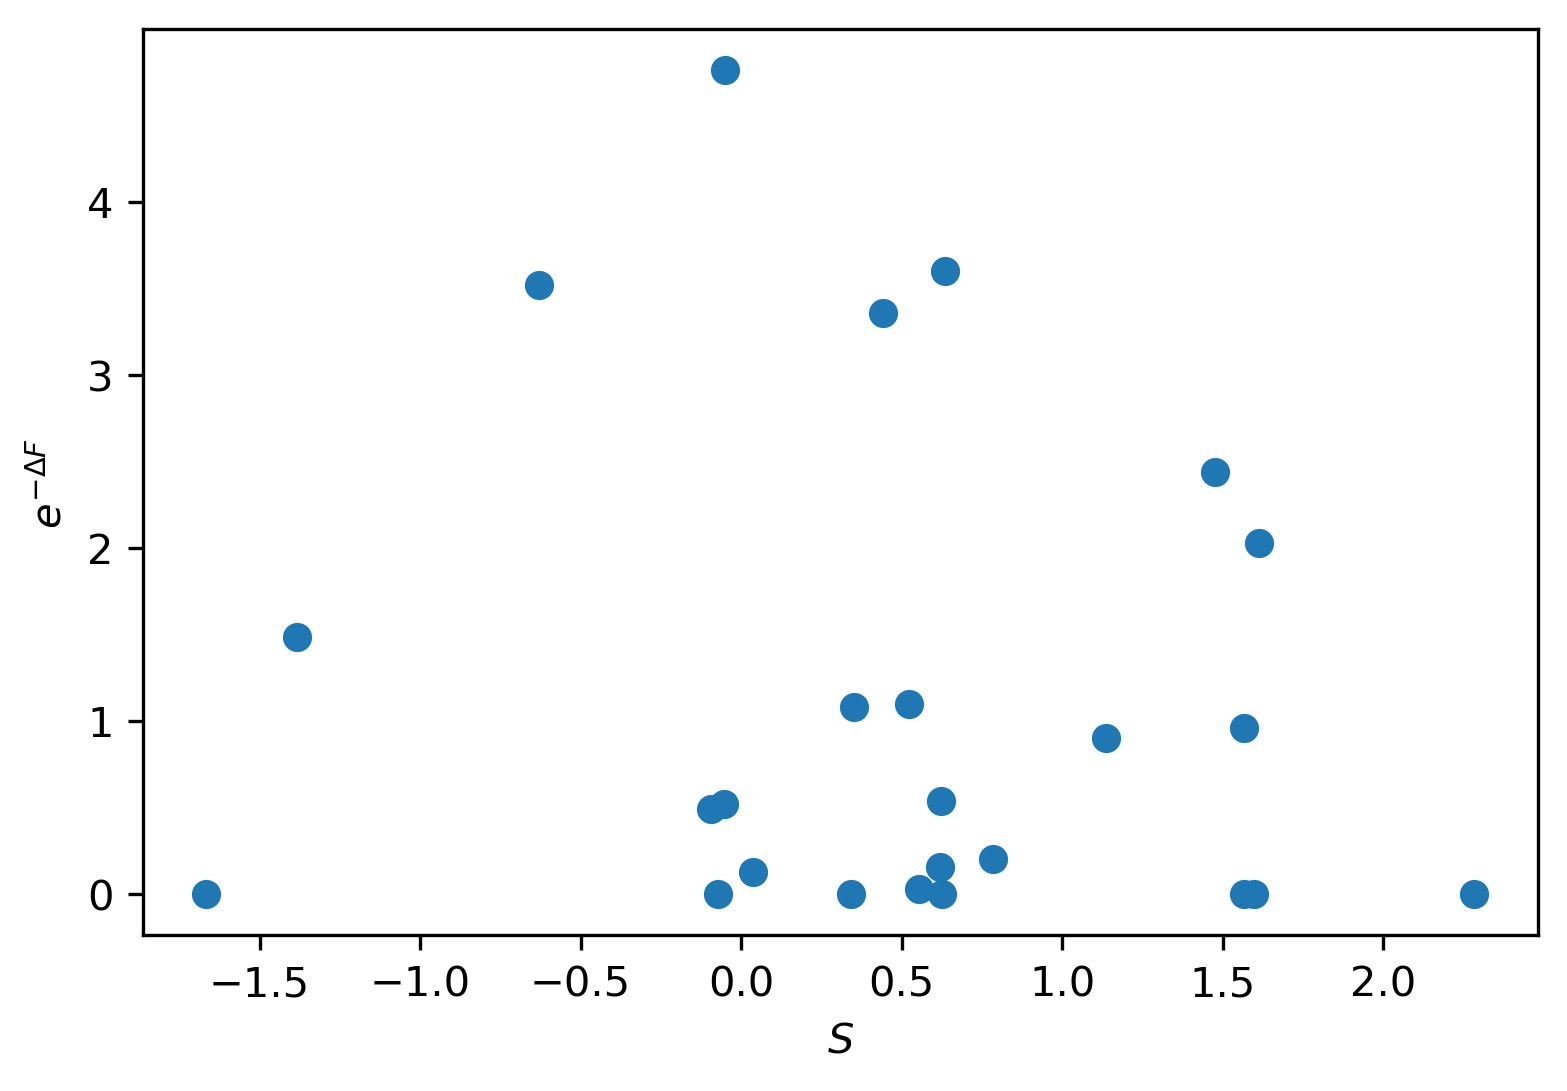

In [136]:
plt.figure(dpi=150)
plt.scatter(frame_soft, np.exp(dF))
plt.xlabel(r"$S$")
plt.ylabel(r"$e^{-\Delta F}$")

In [72]:
for i, (t, d) in enumerate(data.items()):
    out_data = {}
    df = pd.read_parquet(d["soft"])
    ids = np.unique(df["ids"])
    frames = np.unique(df["frames"])
    frame = int(frames[0])
    frame_data = {}
    traj_file = d["traj"]
    snap = gsd.hoomd.open(str(traj_file))[frame]
    dF = run_ff_job(snap, ids, 1234+i, t)
    frame_data["dF"] = dF
    frame_data["S"] = df[df.frames == frame].softness.values
    out_data[frame] = frame_data
    data[t]["ff"] = out_data
    break

temp: 0.64
    id: 2
    barrier: 0.3243752398182254
A barrier crossings: 51
state: 0
barrier: 0 0.3343752398182254 (1.0)
barrier: 1 0.34437523981822543 (0.88)
barrier: 2 0.35437523981822544 (0.1590909090909091)
barrier: 3 0.3575570580000436 (0.42857142857142855)
barrier: 4 0.36028433072731636 (0.5952380952380952)
barrier: 5 0.3635310839740696 (0.26)
barrier: 6 0.36521939566238126 (0.23076923076923078)
barrier: 7 0.36621939566238126 (0.5111111111111111)
barrier: 8 0.36724161788460347 (0.32608695652173914)
barrier: 9 0.36824161788460347 (0.4222222222222222)
barrier: 10 0.36924161788460347 (0.2631578947368421)
barrier: 11 0.37024161788460347 (0.16)
barrier: 12 0.37124161788460347 (0.0)
final rate: 0.0
state: 1
barrier: 0 0.3343752398182254 (1.0)
barrier: 1 0.34437523981822543 (0.96)
barrier: 2 0.35437523981822544 (0.75)
barrier: 3 0.36437523981822545 (0.6944444444444444)
barrier: 4 0.37437523981822546 (0.52)
barrier: 5 0.38437523981822547 (0.5769230769230769)
barrier: 6 0.394375239818225

ValueError: too many values to unpack (expected 2)

In [50]:
data.values().__iter__().__next__()["ff"][0]["dF"].shape

(3278,)

In [26]:
sim.basin_barrier = 0.2936840136269137

In [ ]:
sim.reset_state()
rate, data = sim.run_ff(10_000, collect=10, trials=500, barrier_step=0.01, flex_step=0.0002, floor=1e-20, op_thresh=sim.basin_barrier+0.1, thresh=0.9, thermalize=10_000)

In [ ]:
sim.PID

In [10]:
sim.reset_state()
rate, data = sim.run_ff(100_000, collect=50, trials=100, barrier_step=0.01, flex_step=0.0002, floor=1e-20, op_thresh=sim.basin_barrier+0.1, thresh=0.9)

A barrier crossings: 74
state: 0
barrier: 0 0.3036840136269137 (0.0)
final rate: 0.0
state: 1
barrier: 0 0.3036840136269137 (0.0)
final rate: 0.0
state: 2
barrier: 0 0.3036840136269137 (1.0)
barrier: 1 0.3136840136269137 (1.0)
barrier: 2 0.32368401362691374 (0.57)
barrier: 3 0.33368401362691374 (0.0)
final rate: 0.0
state: 3
barrier: 0 0.3036840136269137 (1.0)
barrier: 1 0.3136840136269137 (1.0)
barrier: 2 0.32368401362691374 (1.0)
barrier: 3 0.33368401362691374 (0.99)
barrier: 4 0.34368401362691375 (0.9797979797979798)
barrier: 5 0.35368401362691376 (0.9072164948453608)
barrier: 6 0.36368401362691377 (0.7159090909090909)
barrier: 7 0.3736840136269138 (0.6190476190476191)
barrier: 8 0.3836840136269138 (0.5641025641025641)
barrier: 9 0.3936840136269138 (0.4431818181818182)
barrier: 10 0.40254764999055015 (0.41025641025641024)
barrier: 11 0.4098203772632774 (0.46875)
barrier: 12 0.41663855908145925 (0.4666666666666667)
barrier: 13 0.4230021954450956 (0.4166666666666667)
barrier: 14 0.428

KeyboardInterrupt: 

In [23]:
rate

4.360650738025834e-16